<a href="https://colab.research.google.com/github/FariusGitHub/DataScience/blob/master/_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Explaination of Elasticsearch computed score number
Farius Tjioesman, April 24, 2021

Ever wondering what formula is behind the elasticsearch _score when es.search was called?<br>
Why the number keep changing although a data was just updated while the version went up?

Localhost:9200 would be setup on Colab instance.<br>
Kibana terminal is not needed for this exercise.

In [168]:
from time import sleep

In [169]:
# install es server
!wget https://artifacts.elastic.co/downloads/elasticsearch/elasticsearch-7.0.0-linux-x86_64.tar.gz -q --show-progress
!tar -xzf elasticsearch-7.0.0-linux-x86_64.tar.gz
!chown -R daemon:daemon elasticsearch-7.0.0

elasticsearch-7.0.0 100%[===================>] 330.70M  42.0MB/s    in 7.7s    


In [170]:
# start server and check es virtual machine connection
import os
from subprocess import Popen, PIPE, STDOUT
es_server = Popen(['elasticsearch-7.0.0/bin/elasticsearch'], 
                  stdout=PIPE, stderr=STDOUT,
                  preexec_fn=lambda: os.setuid(1)  # as daemon
                 )
# wait a bit then test
!curl -X GET "localhost:9200/"

{
  "name" : "c0dad698fc4d",
  "cluster_name" : "elasticsearch",
  "cluster_uuid" : "X48WylC7Q3WBlrc18b8nOg",
  "version" : {
    "number" : "7.0.0",
    "build_flavor" : "default",
    "build_type" : "tar",
    "build_hash" : "b7e28a7",
    "build_date" : "2019-04-05T22:55:32.697037Z",
    "build_snapshot" : false,
    "lucene_version" : "8.0.0",
    "minimum_wire_compatibility_version" : "6.7.0",
    "minimum_index_compatibility_version" : "6.0.0-beta1"
  },
  "tagline" : "You Know, for Search"
}


In [171]:
# client-side
!pip install elasticsearch -q
from elasticsearch import Elasticsearch
es = Elasticsearch()
es.ping()  # got True

True

In [172]:
# RESET the index, wipe off all the versions
es.indices.delete(index='megacorp', ignore=[400, 404])

{'acknowledged': True}

In [173]:
#Ingest first dataset
#To increase the version it would be run 4x for example with iteration below
for i in range(4):
  e1={
      "first_name":"Indrani",
      "last_name":"Bhattacharya",
      "age": 27,
      "about": "KNN, XGBoost, LDA",
      "interests": ['Toastmaster','PMI'],
  }
  res = es.index(index='megacorp',doc_type='employee',id=1,body=e1)

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchWarning)


In [174]:
#Ingest second dataset 
#To increase the version it would be run it 3x for example
for j in range(3):
  e2={
      "first_name" :  "David",
      "last_name" :   "Tian",
      "age" :         32,
      "about" :       "Best Teaching Assistant",
      "interests":  [ "Big Data" ]
  }
  res=es.index(index='megacorp',doc_type='employee',id=2,body=e2)

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document index requests is deprecated, use the typeless endpoints instead (/{index}/_doc/{id}, /{index}/_doc, or /{index}/_create/{id}).
  warnings.warn(message, category=ElasticsearchWarning)


In [175]:
#Check out if the _version of _id 1 is 4
es.get(index='megacorp',doc_type='employee',id=1)

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document get requests is deprecated, use the /{index}/_doc/{id} endpoint instead.
  warnings.warn(message, category=ElasticsearchWarning)


{'_id': '1',
 '_index': 'megacorp',
 '_primary_term': 1,
 '_seq_no': 3,
 '_source': {'about': 'KNN, XGBoost, LDA',
  'age': 27,
  'first_name': 'Indrani',
  'interests': ['Toastmaster', 'PMI'],
  'last_name': 'Bhattacharya'},
 '_type': 'employee',
 '_version': 4,
 'found': True}

In [176]:
#Check out if the _version of _id 2 is 3
es.get(index='megacorp',doc_type='employee',id=2)

/usr/local/lib/python3.7/dist-packages/elasticsearch/connection/base.py:200: ElasticsearchWarning: [types removal] Specifying types in document get requests is deprecated, use the /{index}/_doc/{id} endpoint instead.
  warnings.warn(message, category=ElasticsearchWarning)


{'_id': '2',
 '_index': 'megacorp',
 '_primary_term': 1,
 '_seq_no': 6,
 '_source': {'about': 'Best Teaching Assistant',
  'age': 32,
  'first_name': 'David',
  'interests': ['Big Data'],
  'last_name': 'Tian'},
 '_type': 'employee',
 '_version': 3,
 'found': True}

In [177]:
#to slowdown Colab and allow elasticsearch to update, unless below cells will return null
sleep(1.0)

In [178]:
#The data is only two (_id 1 and _id 2), but the _versions are 4 and 3
res= es.search(index='megacorp',body={'query':{'match_all':{}}})
print('Got '+str(res['hits']['total']['value'])+' hits')

Got 2 hits


https://www.wolframalpha.com/input/?i=0.8266786

In [179]:
#Check the score from above website 
res= es.search(index='megacorp',body={'query':{'match':{'first_name':'david'}}})
res['hits']['hits']

[{'_id': '2',
  '_index': 'megacorp',
  '_score': 0.8266786,
  '_source': {'about': 'Best Teaching Assistant',
   'age': 32,
   'first_name': 'David',
   'interests': ['Big Data'],
   'last_name': 'Tian'},
  '_type': 'employee'}]

Above example showed _score = 0.8266786 <br>
From WolframAlpha that is equal to log 16/7<br>
Therefore elasticsearch _score is as follow

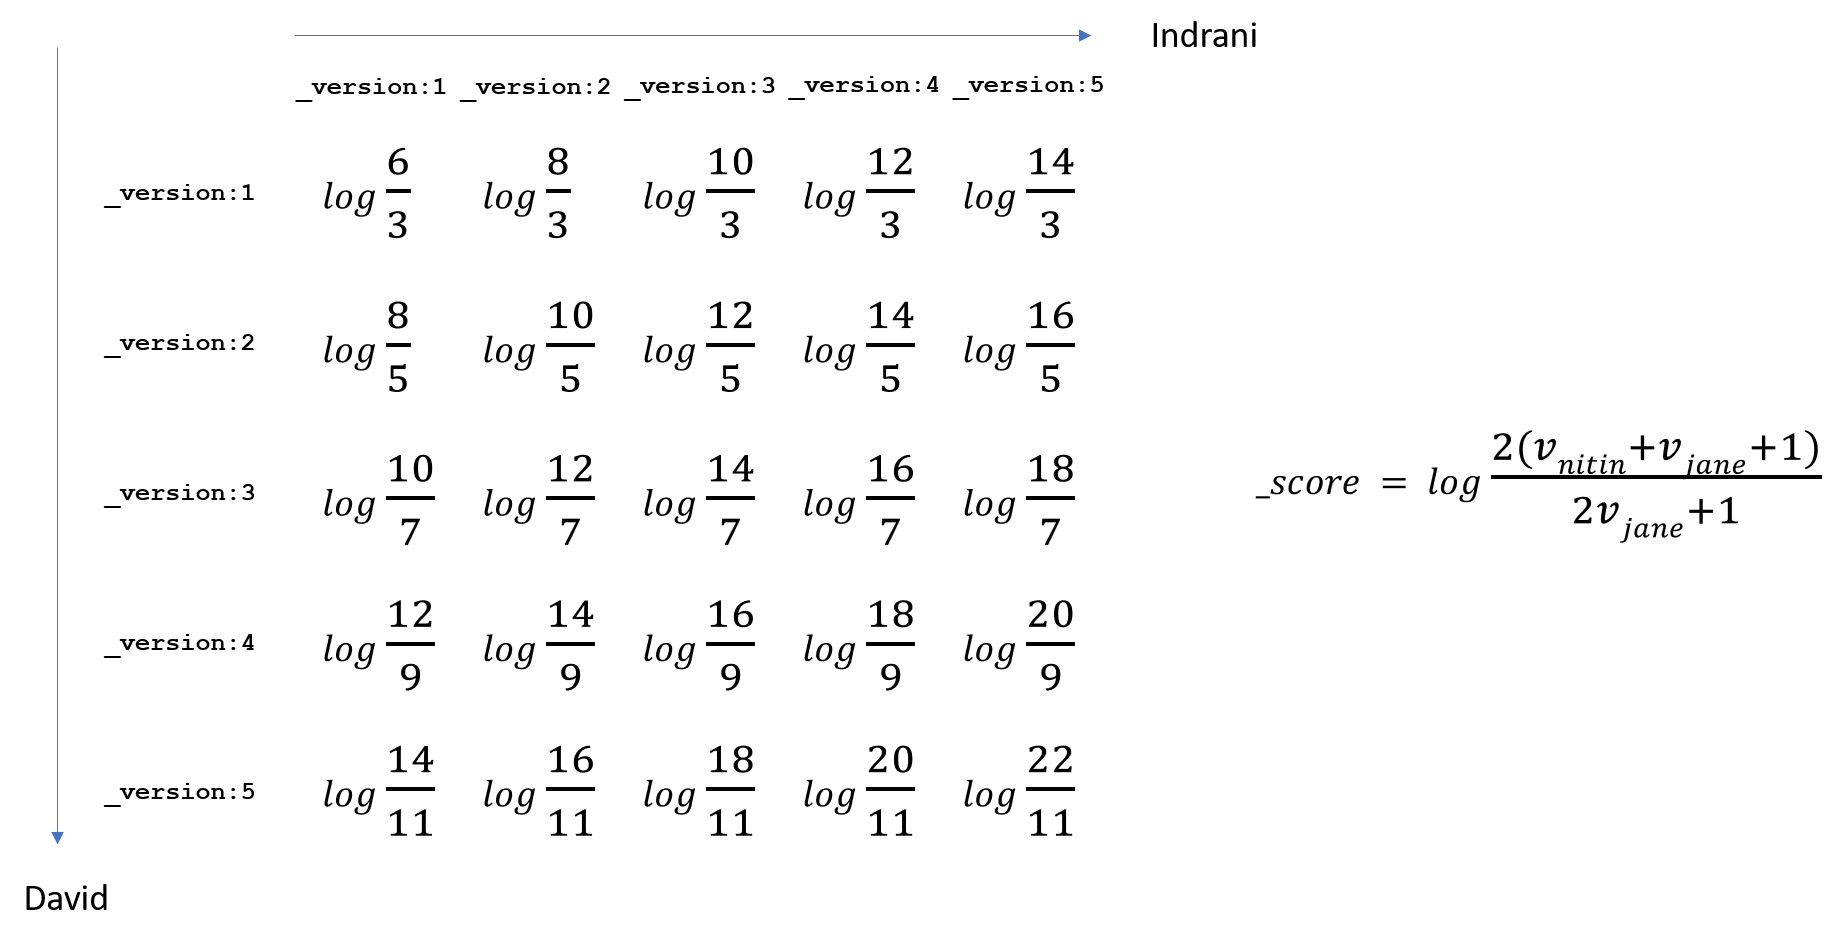